      group 8 : Srijeet Chatterjee, Vishal and Ravi Shankar

#### Load the libraries 

In [36]:
from skimage import io as skio
from PIL import Image
import numpy as np
import os
import sys
from numpy import linalg as LA
import matplotlib.pyplot as plt 

number = 30

#### Function to read the data from folders:

In [37]:
def read_images(path, sz=None):
    c = 0
    X = []
    y =  []
    
    for dirname , dirnames , filenames in os.walk(path):

        for subdirname in dirnames:
            #print(subdirname)
            
            subject_path = os.path.join(dirname , subdirname)
            
            for filename in os.listdir(subject_path):
                
                im = Image.open(os.path.join(subject_path , filename))
                im = im.convert("L")
                image_numpy = np.asarray(np.asarray(im, dtype=np.uint8))
                X.append(image_numpy)
                y.append(c)
                
            c = c+1
            
    return [X,y]

#### Load the Train & Test Data

In [39]:
path_train = 'C:\\Users\\SrijeetChatterjee\\Desktop\\ML-Ninja\\ELL784_IIT_Delhi_Assignments\\data_pca_yalefaces\\Train_Set'
files = os.listdir(path_train)

In [40]:
path_test = 'C:\\Users\\SrijeetChatterjee\\Desktop\\ML-Ninja\\ELL784_IIT_Delhi_Assignments\\data_pca_yalefaces\\Test_Set'
files_test = os.listdir(path_test)

In [41]:
[X,y] = read_images(path_train)
[X_test,y_test] = read_images(path_test)

In [42]:
print(len(X))
print(len(y))
print(len(X_test))
print(len(y_test))

135
135
30
30


In [43]:
print(X[0].shape)
print(X[0].shape[0] * X[0].shape[1])

(243, 320)
77760


#### Train and Test Data_Set creation from the List of Images

In [44]:
#For training :
items = len(X)
[dim1,dim2] = X[0].shape
data_mat = np.empty([0,dim1*dim2])
    
for i in range(items):
    [m,n] = (X[i]).shape
    d = m*n
    x_temp = X[i].reshape(1,d)
    data_mat = np.vstack((data_mat,x_temp))

In [9]:
#For testing :

items_test = len(X_test)
[dim1_test,dim2_test] = X_test[0].shape
data_mat_test = np.empty([0,dim1_test*dim2_test])
    
for i in range(items_test):
    [m,n] = (X_test[i]).shape
    d = m*n
    x_temp_test = X[i].reshape(1,d)
    data_mat_test = np.vstack((data_mat_test,x_temp))

In [10]:
print(data_mat.shape)
print(data_mat_test.shape)

(135, 77760)
(30, 77760)


#### High-Resolution  -------------> Low Resolution 

In [11]:
def process(path,path2,path3,file):
    im = skio.imread(path + file)
    sizeim = [im.shape[0] // 4, im.shape[1] // 4]
    highres = [sizeim[0] * 4, sizeim[1] * 4]

    HRim = im[0:highres[0], 0:highres[1], ...]
    skio.imsave(path2 + file[0:-3] + 'gif', HRim)

    #LRim = scm.imresize(HRim, sizeim, interp='bicubic')
    #skio.imsave(path3 + file[0:-3] + 'gif', LRim)

### Eighen Faces 

#### Define PCA

In [12]:
def PCA(X,y,num):
    
    items = len(X)
    [dim1,dim2] = X[0].shape
    data_mat = np.empty([0,dim1*dim2])
    
    for i in range(items):
        [m,n] = (X[i]).shape
        d = m*n
        x_temp = X[i].reshape(1,d)
        data_mat = np.vstack((data_mat,x_temp))
        
    no_samples = data_mat.shape[0]
    no_dimension = data_mat.shape[1]
    
    mu = np.mean(data_mat,axis = 0)
    
    data_mat_mean = data_mat - mu

    if no_samples > no_dimension:
        cov_mat = np.dot(data_mat_mean.T,data_mat_mean)
    if no_samples <= no_dimension:
        cov_mat = np.dot(data_mat_mean,data_mat_mean.T)
    
    [cov_dim_1,cov_dim_2] = cov_mat.shape
    
    [eigenvalues ,eigenvectors] = LA.eigh(cov_mat)
    
    eigenvectors = np.dot(data_mat_mean.T,eigenvectors)
    
    for i in range(no_samples):
        val = LA.norm(eigenvectors[:,i])
        eigenvectors[:,i] = eigenvectors[:,i]/ val

    sorting_indexes = np.argsort(-eigenvalues,axis= -1, kind='quicksort', order=None)
    
    final_eigvectors =  np.empty([no_dimension,0])
    
    final_eigvals = np.zeros(num)
    
    for i in range(num):
        index = sorting_indexes[i]
        final_eigvals[i] = eigenvalues[index]
        temp = eigenvectors[:,index]
        final_eigvectors = np.hstack((final_eigvectors,temp.reshape(no_dimension,1)))
    
    print(final_eigvals)    
    return [final_eigvals , final_eigvectors , mu]

#### Projecting the data into Lower dimension

In [13]:
def projection(W,X,mean):
    nomalized_images_set = np.subtract(X,mean)
    projected_image_matrix = np.dot(nomalized_images_set,W)
    return projected_image_matrix

#### Getting the image back into original dimension

In [14]:
def reconstruct(W,Y,mean):
    converted_in_space = np.dot(Y,W.T)
    nomalized_image = converted_in_space + mean
    return nomalized_image

#### Eigenfaces model Class

In [15]:
class EigenfacesModel():
    
    def __init__(self,X = None, y = None, num = 30):
        self.num = num
        self.projections = []
        self.W = []
        self.mu = []
        self.X = X
        self.y = y
        self.compute(X,y)
        
    def compute(self,X,y):
        
        [ D, self.W, self.mu ] = PCA(X,y,self.num)
        self.y = y
        
        for xi in X:
            
            xi_res = xi.reshape(1,-1)
            W = self.W
            mu = self.mu
            n_projection = projection(W,xi_res,mu)
            self.projections.append(n_projection)
       
    def predict(self,X):
         
         minDist = sys.float_info.max   # np.finfo('float').max = 1.7976931348623157e+308
         Class = -1
         
         Q = projection(self.W,X.reshape(1,-1),self.mu)
         q = np.asarray(Q).flatten()
         
         for i in range(len(self.projections)):
             
             P = self.projections[i]; 
             p = np.asarray(P).flatten()
             
             
             dist = np.sqrt( np.sum(np.power((p-q),2)))
            
             if dist < minDist:
                 minDist = dist
                 Class = self.y[i]
         return Class

In [16]:
'''-----Lets create the model and start predicting----------------------'''

number = 30 
model = EigenfacesModel(X[0:], y[0:],number)

correct_prediction_count = 0

for i in range (len(X_test)):
    
    predicted_class = model.predict( X_test[i] )
    print ("Actual Class  = ", y_test[i], "/", " Predicted Class = ", predicted_class )
    if y_test[i]== predicted_class:
        correct_prediction_count = correct_prediction_count+1

Efficiency  = correct_prediction_count / len(X_test)  
print(Efficiency * 100 )

[1.46578779e+10 6.81259504e+09 4.25013996e+09 3.61191582e+09
 2.13734353e+09 1.83222195e+09 1.29881590e+09 1.07079734e+09
 9.83946599e+08 8.68200506e+08 6.57250222e+08 5.41783920e+08
 4.49378125e+08 4.35637348e+08 4.29199329e+08 3.77847414e+08
 3.65499127e+08 3.36077301e+08 3.08269490e+08 2.76619831e+08
 2.37550119e+08 2.26425174e+08 2.17652164e+08 2.06176506e+08
 1.94251960e+08 1.81657603e+08 1.68748352e+08 1.57968797e+08
 1.52937465e+08 1.43237289e+08]
Actual Class  =  0 /  Predicted Class =  0
Actual Class  =  0 /  Predicted Class =  0
Actual Class  =  1 /  Predicted Class =  1
Actual Class  =  1 /  Predicted Class =  1
Actual Class  =  2 /  Predicted Class =  2
Actual Class  =  2 /  Predicted Class =  2
Actual Class  =  3 /  Predicted Class =  3
Actual Class  =  3 /  Predicted Class =  3
Actual Class  =  4 /  Predicted Class =  4
Actual Class  =  4 /  Predicted Class =  4
Actual Class  =  5 /  Predicted Class =  5
Actual Class  =  5 /  Predicted Class =  5
Actual Class  =  6 /  Pre

#### Now lets Project the EigenVectors

[1.46578779e+10 6.81259504e+09 4.25013996e+09 3.61191582e+09
 2.13734353e+09 1.83222195e+09 1.29881590e+09 1.07079734e+09
 9.83946599e+08 8.68200506e+08 6.57250222e+08 5.41783920e+08
 4.49378125e+08 4.35637348e+08 4.29199329e+08 3.77847414e+08
 3.65499127e+08 3.36077301e+08 3.08269490e+08 2.76619831e+08
 2.37550119e+08 2.26425174e+08 2.17652164e+08 2.06176506e+08
 1.94251960e+08 1.81657603e+08 1.68748352e+08 1.57968797e+08
 1.52937465e+08 1.43237289e+08]


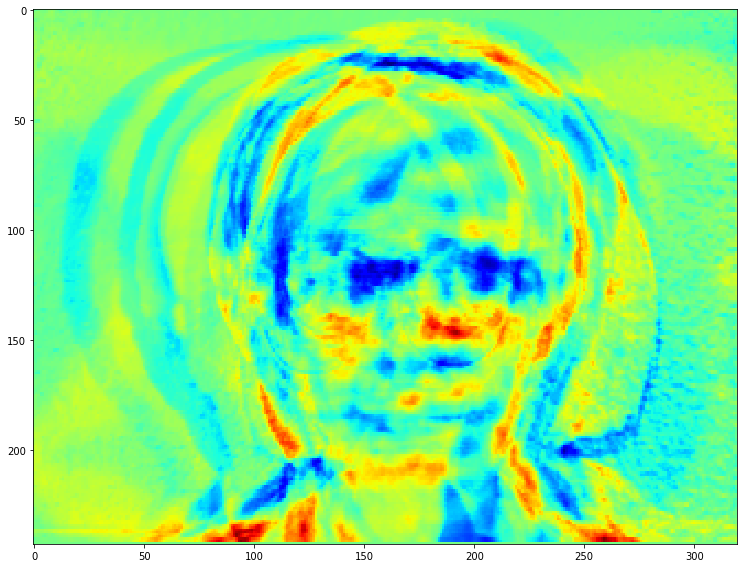

In [17]:
[D_pca, W_pca, mu_pca] = PCA(X, y, number)

#Eigenfaces do not only encode facial features, but also the illumination in the image
path_eigenfaces = 'C:\\Users\\SrijeetChatterjee\\Desktop\\ML-Ninja\\ELL784_IIT_Delhi_Assignments\\output\\Eigenfaces_Vectors\\'

#path_eigenfaces = '/Users/srijeetchatterjee/Desktop/PYTHON_ML/Assignmet_2_ELL784/srijeet/Eigenfaces_Vectors/'

for i in range(30):
    e = W_pca[:,i].reshape((X[0].shape))
    plt.tight_layout()
    plt.gcf().set_size_inches(15,8)
    plt.imshow(e,cmap = 'jet')
    plt.imsave((path_eigenfaces + str(i) + ".png"),e,cmap = 'jet')

#### Visualize the images together

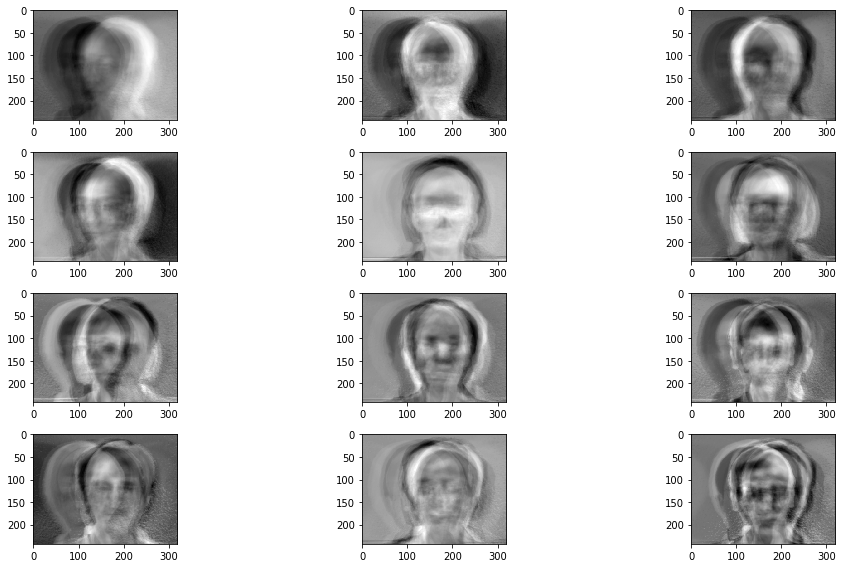

In [18]:
rows = 4

for i in range(12):
    plt.subplot(rows,3,i+1)
    e = W_pca[:,i].reshape((X[0].shape))
    plt.tight_layout()
    plt.gcf().set_size_inches(15,8)
    plt.imshow(e,cmap = 'gray')
    
    #Image.fromarray(e).show() ii

#### Now project and reconstruct and plot

In [19]:
projected_image = projection(model.W,X[6].reshape(1,-1),model.mu)
reconstructed_image = reconstruct(model.W,projected_image,model.mu)
img =  Image.fromarray(reconstructed_image.reshape(X[6].shape))
img.show()
#img.save('my.png')

### FISHER FACES

#### Fisherfaces Model Class

In [20]:
class FisherfacesModel():
    
    def __init__(self,X = None, y = None,num = 30):
        self.num = 30
        self.projections = []
        self.W = []
        self.mu = []
        self.X = X
        self.y = y
        self.compute(X,y)
        #self.num = num
        
    def compute(self, X, y):
        
        [D, self.W, self.mu] = fisherfaces(X,y, self.num)
        self.y = y
        
        for xi in X:
            self.projections.append(projection(self.W, xi.reshape(1,-1), self.mu))

    def predict(self,X):
         
         minDist = sys.float_info.max   # np.finfo('float').max = 1.7976931348623157e+308
         Class = -1
         
         Q = projection(self.W,X.reshape(1,-1),self.mu)
         q = np.asarray(Q).flatten()
         
         for i in range(len(self.projections)):
             
             P = self.projections[i]; 
             p = np.asarray(P).flatten()
             
             
             dist = np.sqrt( np.sum(np.power((p-q),2)))
            
             if dist < minDist:
                 minDist = dist
                 Class = self.y[i]
         return Class

#### Defining LDA 

In [21]:

def lda(X, y, num_components = 30):
    
    no_of_features = X.shape[1]
    
    data_mat = X
    y = np.asarray(y, dtype = np.int64, order = None)
    
    mean = np.mean(data_mat,axis = 0)  #mean of the dataset
    
    
    unique,unique_indices,unique_inverse,unique_counts = np.unique(y, return_index=True, return_inverse=True, return_counts=True, axis=None)
        
    S_w = np.zeros((data_mat.shape[1], data_mat.shape[1]), dtype = np.float32) 
    S_b = np.zeros((data_mat.shape[1], data_mat.shape[1]), dtype = np.float32)
    
    for i in unique:
        
        temp_mat = np.zeros(shape = (0 , data_mat.shape[1]) )
        
        positions = np.where(y == i)[0]
        
        for j in range(len(positions)):
            index = positions[j]
            temp_mat = np.vstack((temp_mat,data_mat[index,:]))
            
        temp_mean = temp_mat.mean(axis=0)
        fac = temp_mat-temp_mean
        new_s_w = np.dot((fac).T, (fac))
        S_w = S_w + new_s_w 
        S_b_component = (temp_mean - mean).reshape((no_of_features,1))
        S_b = S_b + (data_mat.shape[0]) * np.dot(S_b_component, S_b_component.T)
        
    eigenvalues , eigenvectors = LA.eig(LA.inv(S_w)*S_b)
    
    idx = np.argsort(-eigenvalues.real,axis = -1,kind='quicksort', order = None)
    eigenvectors = eigenvectors[:,idx]
    eigenvalues = eigenvalues[idx] 
    fin_eigval =  eigenvalues[0:num_components].real
    eigenvalues = np.array(fin_eigval, dtype=np.float32, copy=True)
    fin_eigvec = eigenvectors[0:,0:num_components].real
    eigenvectors = np.array(fin_eigvec, dtype=np.float32,copy=True)
            
    return [eigenvalues , eigenvectors]

In [22]:
def fisherfaces(X,y,num):
    
    
    items = len(X)
    [dim1,dim2] = X[0].shape
    data_mat = np.empty([0,dim1*dim2])
    
    for i in range(items):
        [m,n] = (X[i]).shape
        d = m*n
        x_temp = X[i].reshape(1,d)
        data_mat = np.vstack((data_mat,x_temp))
    
    
    y = np.asarray(y, dtype = np.int64, order = None)
        
    c = len(np.unique(y))
    
    [eigenvalues_pca , eigenvectors_pca ,mu_pca] = PCA(X, y, (data_mat.shape[0]-c))
    
    projected_data_set = np.dot( (data_mat- mu_pca), eigenvectors_pca )
    
    [eigenvalues_lda , eigenvectors_lda] = lda(projected_data_set,y,num)
    
    eigenvectors = np.dot(eigenvectors_pca ,eigenvectors_lda) 
    
    return [eigenvalues_lda , eigenvectors , mu_pca]

In [23]:
# eigenvalues_lda = (no_of_components,)
# eigenvectors =    (no_features_in_original_data_matrix , no_of_components)
# mu_pca = (no_features_in_original_data_matrix,)

#### Lets create the Fisher Class object & start predicting

In [24]:
model_1 = FisherfacesModel(X[0:], y[0:],number)

correct_prediction_count = 0

for i in range (len(X_test)):
    
    predicted_class = model_1.predict( X_test[i] )
    print ("Actual Class  = ", y_test[i], "/", " Predicted Class = ", predicted_class )
    if y_test[i]== predicted_class:
        correct_prediction_count = correct_prediction_count+1

Efficiency  = correct_prediction_count / len(X_test)  
print(Efficiency * 100 )

[1.46578779e+10 6.81259504e+09 4.25013996e+09 3.61191582e+09
 2.13734353e+09 1.83222195e+09 1.29881590e+09 1.07079734e+09
 9.83946599e+08 8.68200506e+08 6.57250222e+08 5.41783920e+08
 4.49378125e+08 4.35637348e+08 4.29199329e+08 3.77847414e+08
 3.65499127e+08 3.36077301e+08 3.08269490e+08 2.76619831e+08
 2.37550119e+08 2.26425174e+08 2.17652164e+08 2.06176506e+08
 1.94251960e+08 1.81657603e+08 1.68748352e+08 1.57968797e+08
 1.52937465e+08 1.43237289e+08 1.36486057e+08 1.31232984e+08
 1.22149869e+08 1.18516311e+08 1.12070624e+08 1.07089010e+08
 9.63878900e+07 9.43464686e+07 9.30306217e+07 8.88180638e+07
 8.40685961e+07 8.13590551e+07 7.84003347e+07 7.46182916e+07
 7.31511955e+07 7.12098718e+07 6.93153630e+07 6.55121110e+07
 6.28456409e+07 6.21855442e+07 6.14486829e+07 5.65979215e+07
 5.58417360e+07 5.42813039e+07 5.20718893e+07 5.10246787e+07
 5.05139654e+07 4.76145396e+07 4.65803332e+07 4.54072423e+07
 4.49101859e+07 4.41929063e+07 4.32957947e+07 4.27379131e+07
 4.15846769e+07 3.982831

#### Project the FisherVectors

[1.46578779e+10 6.81259504e+09 4.25013996e+09 3.61191582e+09
 2.13734353e+09 1.83222195e+09 1.29881590e+09 1.07079734e+09
 9.83946599e+08 8.68200506e+08 6.57250222e+08 5.41783920e+08
 4.49378125e+08 4.35637348e+08 4.29199329e+08 3.77847414e+08
 3.65499127e+08 3.36077301e+08 3.08269490e+08 2.76619831e+08
 2.37550119e+08 2.26425174e+08 2.17652164e+08 2.06176506e+08
 1.94251960e+08 1.81657603e+08 1.68748352e+08 1.57968797e+08
 1.52937465e+08 1.43237289e+08 1.36486057e+08 1.31232984e+08
 1.22149869e+08 1.18516311e+08 1.12070624e+08 1.07089010e+08
 9.63878900e+07 9.43464686e+07 9.30306217e+07 8.88180638e+07
 8.40685961e+07 8.13590551e+07 7.84003347e+07 7.46182916e+07
 7.31511955e+07 7.12098718e+07 6.93153630e+07 6.55121110e+07
 6.28456409e+07 6.21855442e+07 6.14486829e+07 5.65979215e+07
 5.58417360e+07 5.42813039e+07 5.20718893e+07 5.10246787e+07
 5.05139654e+07 4.76145396e+07 4.65803332e+07 4.54072423e+07
 4.49101859e+07 4.41929063e+07 4.32957947e+07 4.27379131e+07
 4.15846769e+07 3.982831

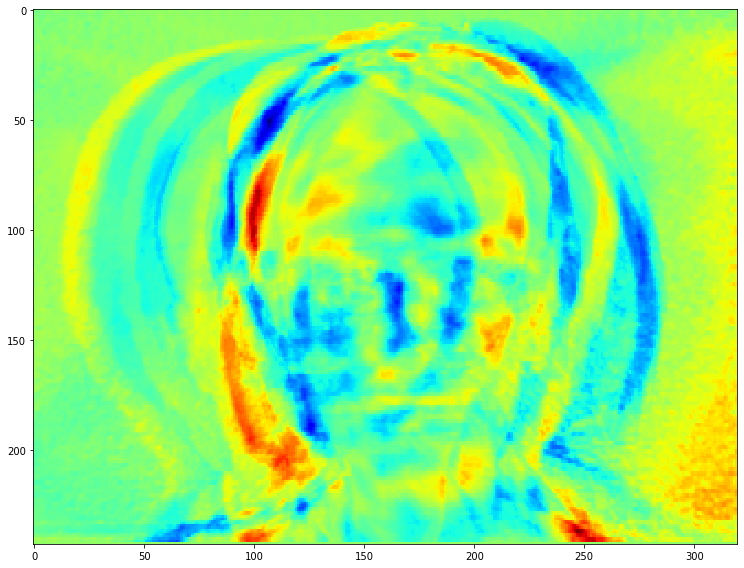

In [25]:
[D_fisher, W_fisher, mu_fisher] = fisherfaces(X, y, number)

#not capture illumination as obviously as the Eigenfaces method. 
#finds the facial features to discriminate between the persons.

#path_fisherfaces = '/Users/srijeetchatterjee/Desktop/PYTHON_ML/Assignmet_2_ELL784/srijeet/Fisherfaces_Vectors/'
path_fisherfaces = 'C:\\Users\\SrijeetChatterjee\\Desktop\\ML-Ninja\\ELL784_IIT_Delhi_Assignments\\output\\Fisherfaces_Vectors\\'

for i in range(16):
    e = W_fisher[:,i].reshape((X[0].shape))
    plt.tight_layout()
    plt.gcf().set_size_inches(15,8)
    plt.imshow(e,cmap = 'jet')
    plt.imsave((path_fisherfaces + str(i) + ".png"),e,cmap = 'jet')

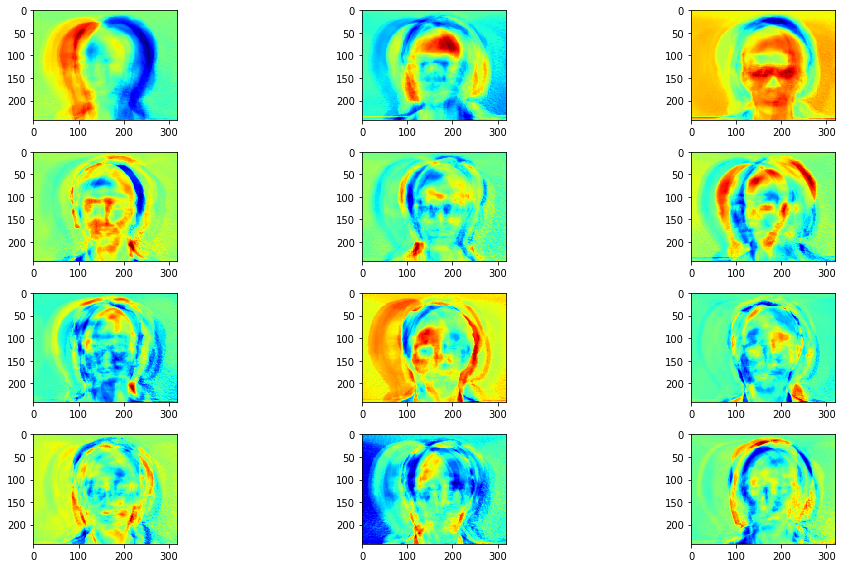

In [26]:
'''-------------------Visualize the images together----------------------------'''    
    
rows = 4

for i in range(12):
    plt.subplot(rows,3,i+1)
    e = W_fisher[:,i].reshape((X[0].shape))
    plt.tight_layout()
    plt.gcf().set_size_inches(15,8)
    plt.imshow(e,cmap = 'jet')
    #Image.fromarray(e).show() ii

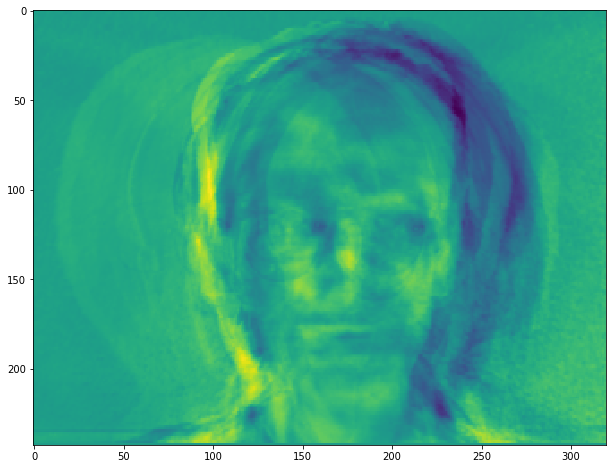

In [27]:
'''---------------Now project and reconstruct and plot----------------------'''

image_to_be_projected = data_mat[0,:]
mean_of_dataset = mu_fisher

#eigenvec_to_use_for_projection = W[:,0]
projected_image = np.dot(image_to_be_projected - mean_of_dataset,W_fisher)
reconstruct_image = np.dot(projected_image.reshape(1,number),W_fisher.T)

plt.tight_layout()
plt.gcf().set_size_inches(15,8)
plt.imshow(reconstruct_image.reshape(X[0].shape))

#img =  Image.fromarray(reconstruct_image.reshape(X[0].shape))
#img.show()